# (04) Vary single ground truth

**Motivation**: Generate from ROFL, does the approximate posterior find a straight line, or a curved line?

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def compute_mu_sd(x, axis: int = 0):
    mu = x.mean(axis, keepdims=True)
    sd = x.std(axis, keepdims=True)
    return mu, sd


from analysis.opticflow import ROFL, Obj, _replace_z
from analysis.linear import mi_analysis

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

## Load

In [3]:
# skip + x
# model_name = 'fixate1_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)'
# fit_name = 'ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_24,18:00)'

# skip + 0.1 * x
model_name = 'fixate1_k-32_z-14x[5,10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'skip+0.1x_ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_05_30,09:01)'

tr, meta = load_model(
    model_name=model_name,
    fit_name=fit_name,
    verbose=False,
    device='cuda',
    shuffle=False,
)

### Linear Regression

In [4]:
%%time

g, select_lbl = prep_rofl(
    labels=list(LBL2TEX) + [
        'slf_v_norm',
        'slf_v_theta',
        'slf_v_phi']
)
z = {
    k: tr.forward(k, True)[0]['z']
    for k in g
}

CPU times: user 6min 42s, sys: 2min 4s, total: 8min 46s
Wall time: 8min 46s


In [5]:
mu_sd = {
    'g': compute_mu_sd(np.concatenate(
        [v for v in g.values()])),
    'z': compute_mu_sd(np.concatenate(
        [v for v in z.values()])),
}

In [6]:
idx = 6
idx, select_lbl[idx]

(6, 'obj0_alpha_y')

In [7]:
lr = sk_linear.LinearRegression().fit(
    shift_rescale(z['trn'], *mu_sd['z']),
    shift_rescale(g['trn'], *mu_sd['g'])[:, idx],
)
pred = lr.predict(shift_rescale(np.concatenate(
    [z['vld'], z['tst']]), *mu_sd['z']))
true = shift_rescale(np.concatenate(
    [g['vld'], g['tst']]), *mu_sd['g'])[:, idx]
r2 = sk_metric.r2_score(true, pred)
r2

0.925726033402866

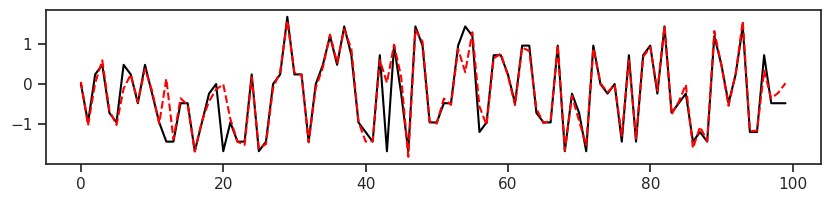

In [8]:
fig, ax = create_figure(1, 1, (10, 2))
ax.plot(true[:100], 'k')
ax.plot(pred[:100], 'r--')
plt.show()

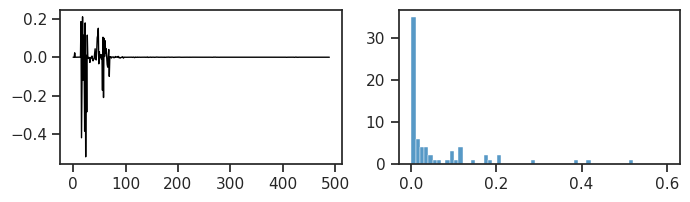

In [9]:
u_hat = lr.coef_ / sp_lin.norm(lr.coef_)

fig, axes = create_figure(1, 2, (8, 2))
axes[0].plot(u_hat, lw=1, color='k')
sns.histplot(np.abs(u_hat), bins=np.linspace(0.001, 0.6 + 0.001, 61), ax=axes[1])
axes[1].set_ylabel('')
plt.show()

## ROFL generate

In [10]:
kws = dict(
    category='fixate',
    n_obj=1,
    dim=17,
    fov=45.0,
    obj_r=0.25,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 1.0),
    vlim_slf=(0.01, 1.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 3.5

{
    'category': 'fixate',
    'n_obj': 1,
    'dim': 17,
    'fov': 45.0,
    'obj_r': 0.25,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 1.0),
    'vlim_slf': (0.01, 1.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [11]:
n = 1000
rofl = ROFL(n=n, **kws)

In [12]:
rofl.compute_coords().compute_flow()
accept = rofl.filter(min_obj_size)
accept.sum() / rofl.n

0.88

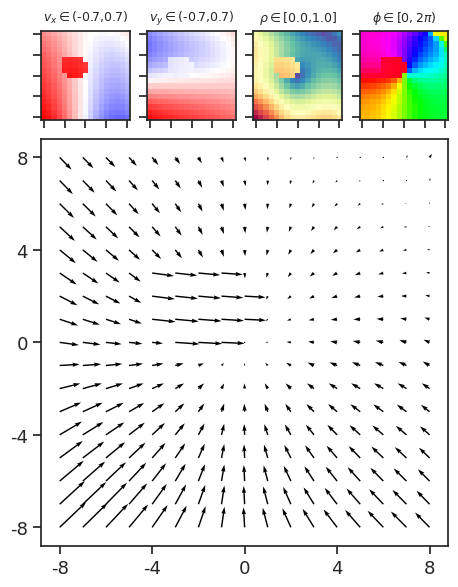

In [16]:
sample_i = 4
show_opticflow_full(rofl.alpha_dot[accept][sample_i]);

In [21]:
attrs_slf = {
    k: np.repeat(
        getattr(rofl, k)[accept][[sample_i]],
        repeats=rofl.dim,
        axis=0,
    ) for k in ['fix', 'v_slf']
}
alpha = np.repeat(
    rofl.objects[0].alpha[accept][[sample_i]],
    repeats=rofl.dim, axis=0)
alpha[:, 1] = rofl.span
attrs_obj = {0: {
    'alpha': alpha,
    'v_obj': np.repeat(
        rofl.objects[0].v[accept][[sample_i]],
        repeats=rofl.dim, axis=0),
    'z': [rofl.objects[0].pos[accept][sample_i, 2]] * rofl.dim,
}}
rofl2 = ROFL(n=rofl.n, **kws)
rofl2.setattrs(attrs_slf, attrs_obj)
_ = rofl2.compute_flow()

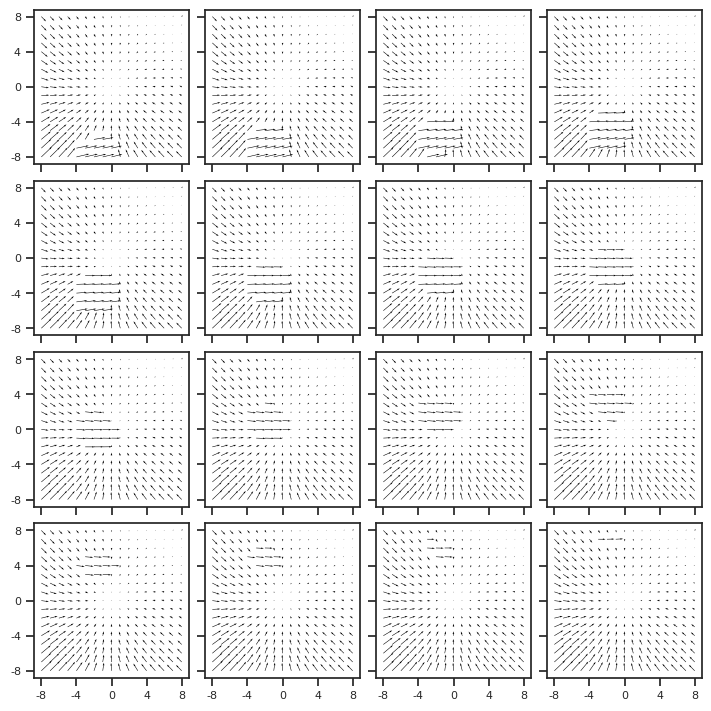

In [22]:
show_opticflow(rofl2.alpha_dot);

In [26]:
x = tr.to(np.transpose(rofl2.alpha_dot, [0, -1, 1, 2]))
latents, _, x_hat, q, p = tr.model.xtract_ftr(x)

In [37]:
z = to_np(torch.cat(latents, dim=1).squeeze().squeeze())
z.shape

(17, 490)

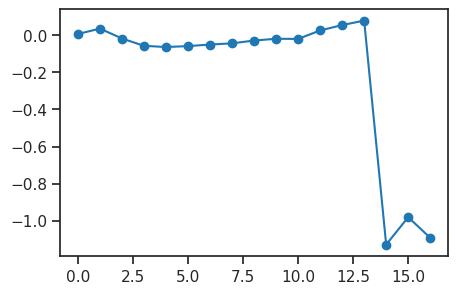

In [109]:
plt.plot(z[:, 34], marker='o')

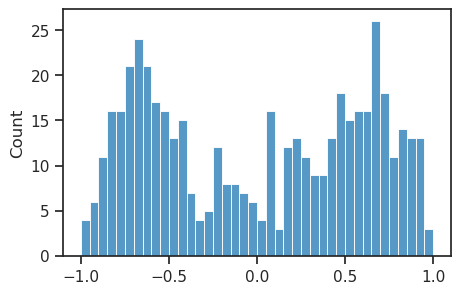

In [67]:
r = 1 - sp_dist.cdist(
    XA=z.T,
    XB=rofl2.objects[0].alpha[:, [1]].T,
    metric='correlation',
).ravel()
sns.histplot(r, bins=np.linspace(-1, 1, 41));

In [75]:
inds = np.where(np.abs(r) > 0.97)[0]
inds

array([ 51,  74,  81, 103, 237])

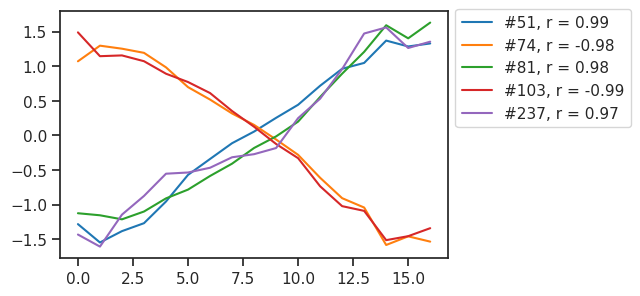

In [84]:
fig, ax = create_figure()
for i, ii in enumerate(inds):
    ax.plot(
        sp_stats.zscore(z[:, ii]),
        label=f'#{ii}, r = {r[ii]:0.2f}',
        color=f'C{i}',
    )
ax.legend(bbox_to_anchor=(1, 1.04))
plt.show()

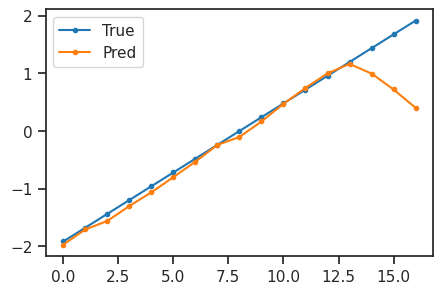

In [125]:
plt.plot(
    shift_rescale(rofl2.objects[0].alpha[:, 1], *(e[:, idx] for e in mu_sd['g'])),
    marker='.',
    label='True',
)
plt.plot(
    lr.predict(shift_rescale(z, *mu_sd['z'])),
    marker='.',
    label='Pred',
)
plt.legend()

### Non linear: squared

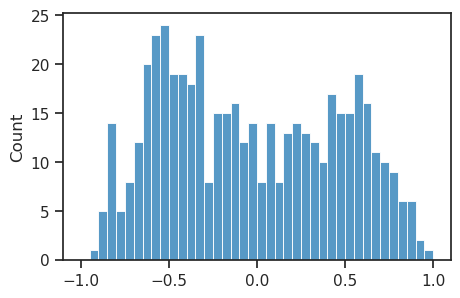

In [126]:
r = 1 - sp_dist.cdist(
    XA=z.T,
    XB=rofl2.objects[0].alpha[:, [1]].T ** 2,
    metric='correlation',
).ravel()
sns.histplot(r, bins=np.linspace(-1, 1, 41));

In [135]:
inds = np.where(np.abs(r) > 0.90)[0]
inds

array([ 72,  78, 204, 484])

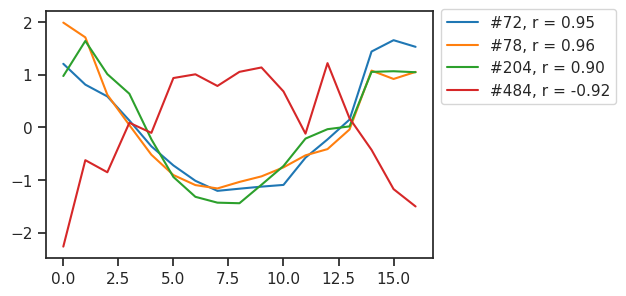

In [136]:
fig, ax = create_figure()
for i, ii in enumerate(inds):
    ax.plot(
        sp_stats.zscore(z[:, ii]),
        label=f'#{ii}, r = {r[ii]:0.2f}',
        color=f'C{i}',
    )
ax.legend(bbox_to_anchor=(1, 1.04))
plt.show()

### Non linear: quadruple

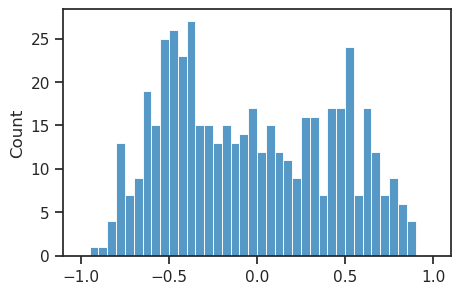

In [140]:
r = 1 - sp_dist.cdist(
    XA=z.T,
    XB=rofl2.objects[0].alpha[:, [1]].T ** 4,
    metric='correlation',
).ravel()
sns.histplot(r, bins=np.linspace(-1, 1, 41));

In [143]:
inds = np.where(np.abs(r) > 0.86)[0]
inds

array([  7,  78, 285, 484])

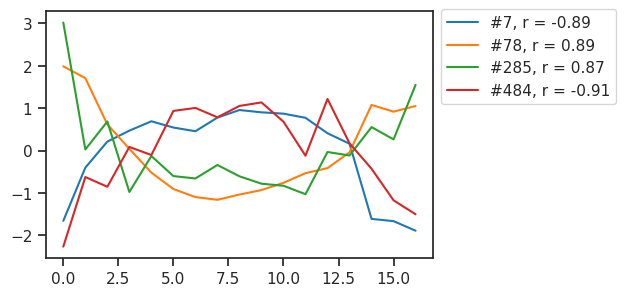

In [144]:
fig, ax = create_figure()
for i, ii in enumerate(inds):
    ax.plot(
        sp_stats.zscore(z[:, ii]),
        label=f'#{ii}, r = {r[ii]:0.2f}',
        color=f'C{i}',
    )
ax.legend(bbox_to_anchor=(1, 1.04))
plt.show()

## Now systematic

In [11]:
kws = dict(
    category='fixate',
    n_obj=1,
    dim=17,
    fov=45.0,
    obj_r=0.25,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 1.0),
    vlim_slf=(0.01, 1.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 3.5

{
    'category': 'fixate',
    'n_obj': 1,
    'dim': 17,
    'fov': 45.0,
    'obj_r': 0.25,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 1.0),
    'vlim_slf': (0.01, 1.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [12]:
n = int(5e4)
rofl = ROFL(n=n, **kws)

In [13]:
rofl.compute_coords().compute_flow()
accept = rofl.filter(min_obj_size)
accept.sum() / rofl.n

0.87366

In [30]:
err = np.zeros((accept.sum(), rofl.dim))
for sample_i in tqdm(range(accept.sum())):
    attrs_slf = {
        k: np.repeat(
            getattr(rofl, k)[accept][[sample_i]],
            repeats=rofl.dim,
            axis=0,
        ) for k in ['fix', 'v_slf']
    }
    alpha = np.repeat(
        rofl.objects[0].alpha[accept][[sample_i]],
        repeats=rofl.dim, axis=0)
    alpha[:, 1] = rofl.span
    attrs_obj = {0: {
        'alpha': alpha,
        'v_obj': np.repeat(
            rofl.objects[0].v[accept][[sample_i]],
            repeats=rofl.dim, axis=0),
        'z': [rofl.objects[0].pos[accept][sample_i, 2]] * rofl.dim,
    }}
    rofl2 = ROFL(n=rofl.n, **kws)
    rofl2.setattrs(attrs_slf, attrs_obj)
    _ = rofl2.compute_flow()
    
    x = tr.to(np.transpose(rofl2.alpha_dot, [0, -1, 1, 2]))
    latents, _, x_hat, q, p = tr.model.xtract_ftr(x)
    latents = to_np(torch.cat(
        latents, dim=1).squeeze().squeeze())
    true = shift_rescale(
        rofl2.objects[0].alpha[:, 1],
        *(e[:, idx] for e in mu_sd['g']),
    )
    pred = lr.predict(shift_rescale(
        latents, *mu_sd['z']))
    err[sample_i] = (pred - true) ** 2

100%|███████████████████████████████████| 43683/43683 [1:16:32<00:00,  9.51it/s]


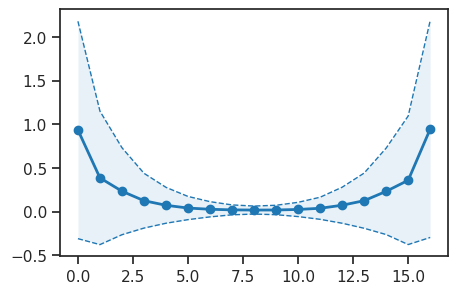

In [46]:
err_mu = err.mean(0)
err_sd = err.std(0)
plt.plot(err_mu, lw=2, marker='o')
plt.plot(err_mu - err_sd, color='C0', ls='--', lw=1)
plt.plot(err_mu + err_sd, color='C0', ls='--', lw=1)
plt.fill_between(range(err.shape[1]), err_mu - err_sd, err_mu + err_sd, alpha=0.1)
plt.show()

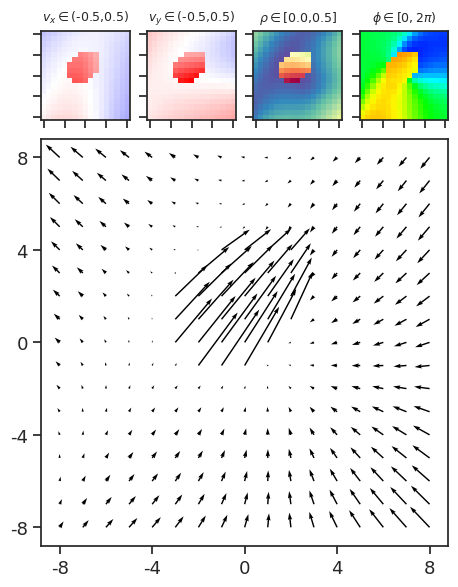

In [47]:
show_opticflow_full(rofl.alpha_dot[accept][sample_i]);

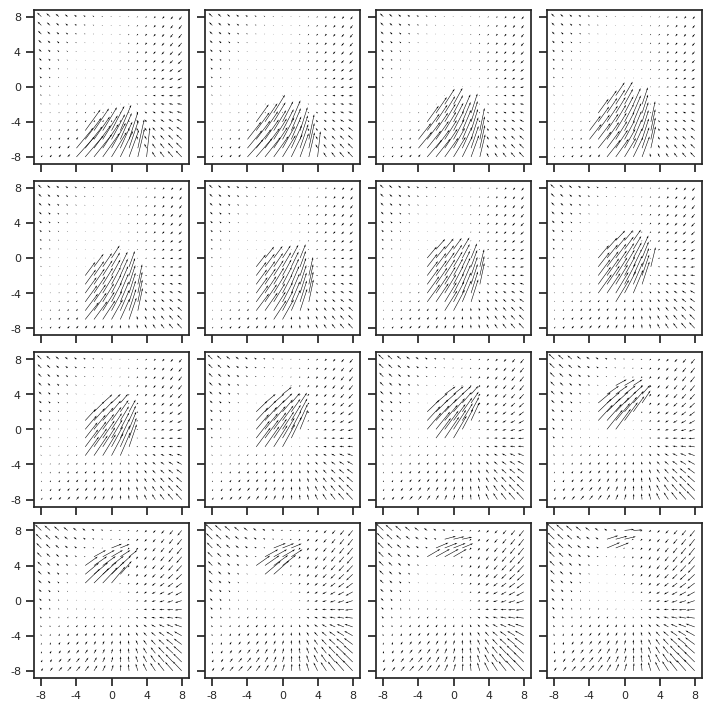

In [48]:
show_opticflow(rofl2.alpha_dot);

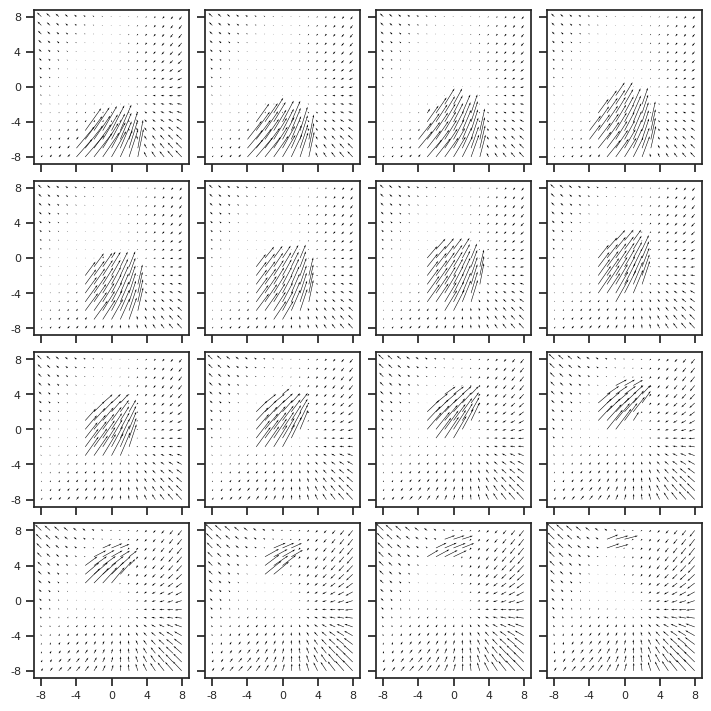

In [49]:
show_opticflow(x_hat);

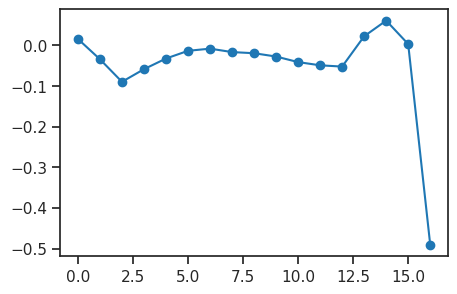

In [51]:
plt.plot(latents[:, 34], marker='o')

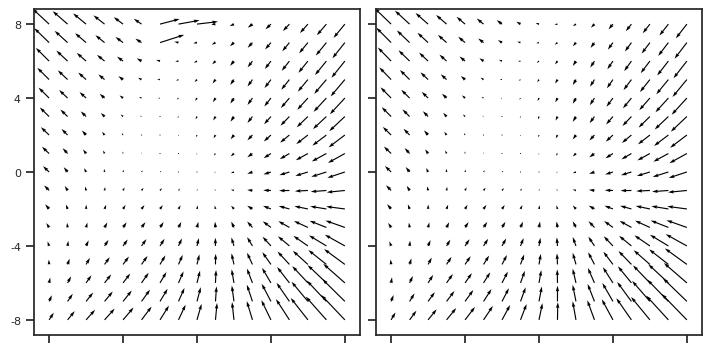

In [71]:
show_opticflow(np.stack([
    rofl2.alpha_dot[-1],
    np.transpose(to_np(x_hat)[-1], (1, 2, 0)),
]), num=2);

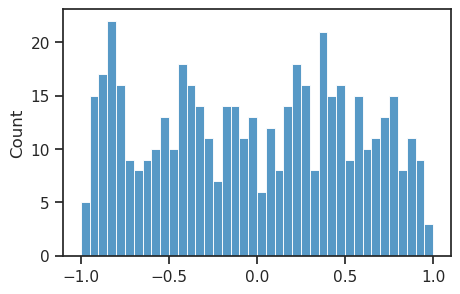

In [72]:
r = 1 - sp_dist.cdist(
    XA=latents.T,
    XB=rofl2.objects[0].alpha[:, [1]].T,
    metric='correlation',
).ravel()
sns.histplot(r, bins=np.linspace(-1, 1, 41));

In [78]:
inds = np.where(np.abs(r) > 0.96)[0]
inds

array([145, 158, 197, 243])

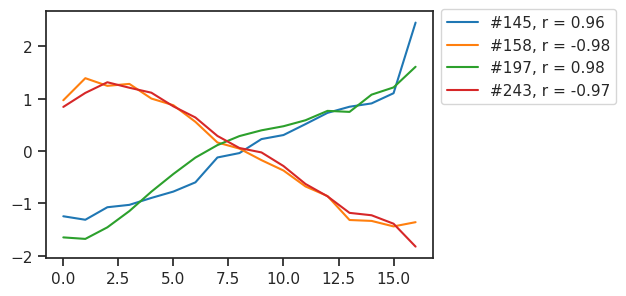

In [79]:
fig, ax = create_figure()
for i, ii in enumerate(inds):
    ax.plot(
        sp_stats.zscore(latents[:, ii]),
        label=f'#{ii}, r = {r[ii]:0.2f}',
        color=f'C{i}',
    )
ax.legend(bbox_to_anchor=(1, 1.04))
plt.show()

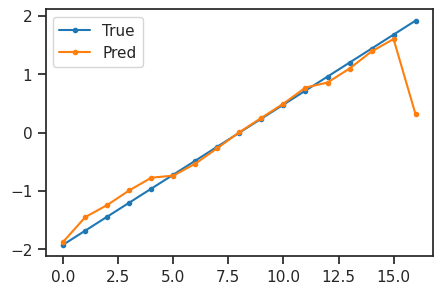

In [80]:
plt.plot(
    true,
    marker='.',
    label='True',
)
plt.plot(
    pred,
    marker='.',
    label='Pred',
)
plt.legend()
plt.show()